In [130]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import nibabel as nib
import matplotlib.pyplot as plt
from google.cloud import storage
import os
from scipy import ndimage
import shutil
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
def get_blobs(bucket_name, prefix):
    """Lists all the blobs in the bucket."""
    storage_client = storage.Client(project = "CS-502")
    bucket = storage_client.get_bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix)
    
    num_blobs = 0
    for blob in blobs: 
        num_blobs +=1
    
    blobs = bucket.list_blobs(prefix=prefix)
        
    return bucket, blobs, num_blobs

In [85]:
def plot_dicom_imgs(blobs, idx_imgs):
    
    lst = sorted(list(blobs), key=lambda b: int(b.name.split('/')[-1].split('.')[0]))
    fig, axs = plt.subplots(1, len(idx_imgs), figsize = (10,5))
    
    for i, ax in enumerate(axs.flatten()):
        img = lst[idx_imgs[i]]
        img.download_to_filename('temp.dcm')
        img = pydicom.dcmread('temp.dcm')
        ax.imshow(img.pixel_array, cmap='gray')
        os.remove('temp.dcm')

In [56]:
def plot_nifti_imgs(blob, l=3):
    list(blob)[0].download_to_filename('temp.nii.gz')
    img = nib.load('temp.nii.gz')
    img = img.get_fdata()
    idx_slices = [i for i in np.arange(0, img.shape[2], (img.shape[2]-1)//(l-1))]
    
    fig, axs = plt.subplots(1, len(idx_slices), figsize = (10,5))
    
    for i, ax in enumerate(axs.flatten()):
        rotated_img = ndimage.rotate(img[:,:,idx_slices[i]], 90)
        ax.imshow(rotated_img, cmap='gray')
        
        
    os.remove('temp.nii.gz')

In [145]:
def plot_segmentations(blob_nifti, blob_segmentation, l=3):
    
    list(blob_nifti)[0].download_to_filename('original.nii.gz')
    img_nifti = nib.load('original.nii.gz')
    img_nifti = img_nifti.get_fdata()
    
    idx_slices = [i for i in np.arange(0, img_nifti.shape[2], (img_nifti.shape[2]-1)//(l-1))]
    print(idx_slices)
    mask_dir = 'mask_dir'
    if not os.path.isdir(mask_dir):
        os.mkdir(mask_dir)
    
    name_masks = []
    for blob in blob_segmentation:
        name_mask = blob.name.split('/')[-1]
        blob.download_to_filename(mask_dir + '/' + name_mask)
        name_masks.append(name_mask)
    
    print(name_masks)
    fig, axs = plt.subplots(9, l, figsize=(8,20))
    
    for i in range(9):
        for k, idx in enumerate(idx_slices):
            mask = nib.load(mask_dir + '/' + name_masks[i])
            mask = mask.get_fdata()
            mask_idx = mask[:,:,idx].astype(bool)
            masked_nifti=np.where(mask_idx, img_nifti[:,:,idx], 0)
            
            rotated_mask = ndimage.rotate(masked_nifti, 90)
            
            axs[i][k].imshow(rotated_mask, cmap='gray', vmin=0, vmax=255)
            axs[i][k].set_title(name_masks[i])
    
    plt.tight_layout()
    
    shutil.rmtree(mask_dir)
        

### Dicom visualizations 

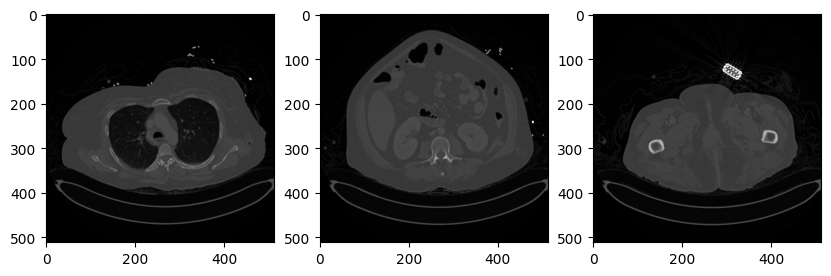

In [86]:
subject_id = 10004
run_id = 21057
folder = 'train_images_fixed/train_images'

_, dicom_blob, len_blob = get_blobs('rsna-competition-2023', folder + '/' + str(subject_id) + '/' + str(run_id))
idx_imgs = [0, len_blob//2, len_blob-1]
plot_dicom_imgs(dicom_blob, idx_imgs)


### Nifti visualizations

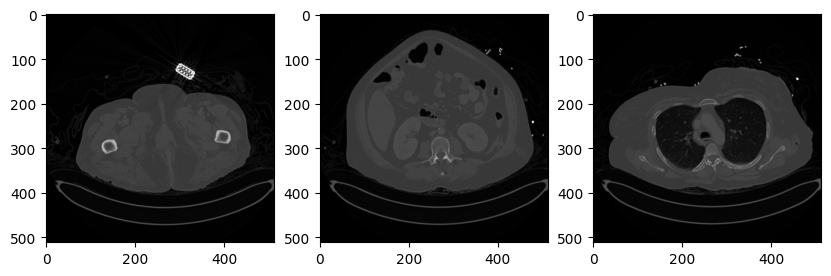

In [128]:
subject_id = 10004
run_id = 21057
folder = 'train_nifti'

_, nifti_blob, len_blob = get_blobs('rsna-competition-2023', folder + '/' + str(subject_id) + '/' + str(run_id))
plot_nifti_imgs(nifti_blob)

### Segmentation visualizations

[0, 34, 68, 102]
['colon.nii.gz', 'duodenum.nii.gz', 'esophagus.nii.gz', 'kidney_left.nii.gz', 'kidney_right.nii.gz', 'liver.nii.gz', 'small_bowel.nii.gz', 'spleen.nii.gz', 'stomach.nii.gz']


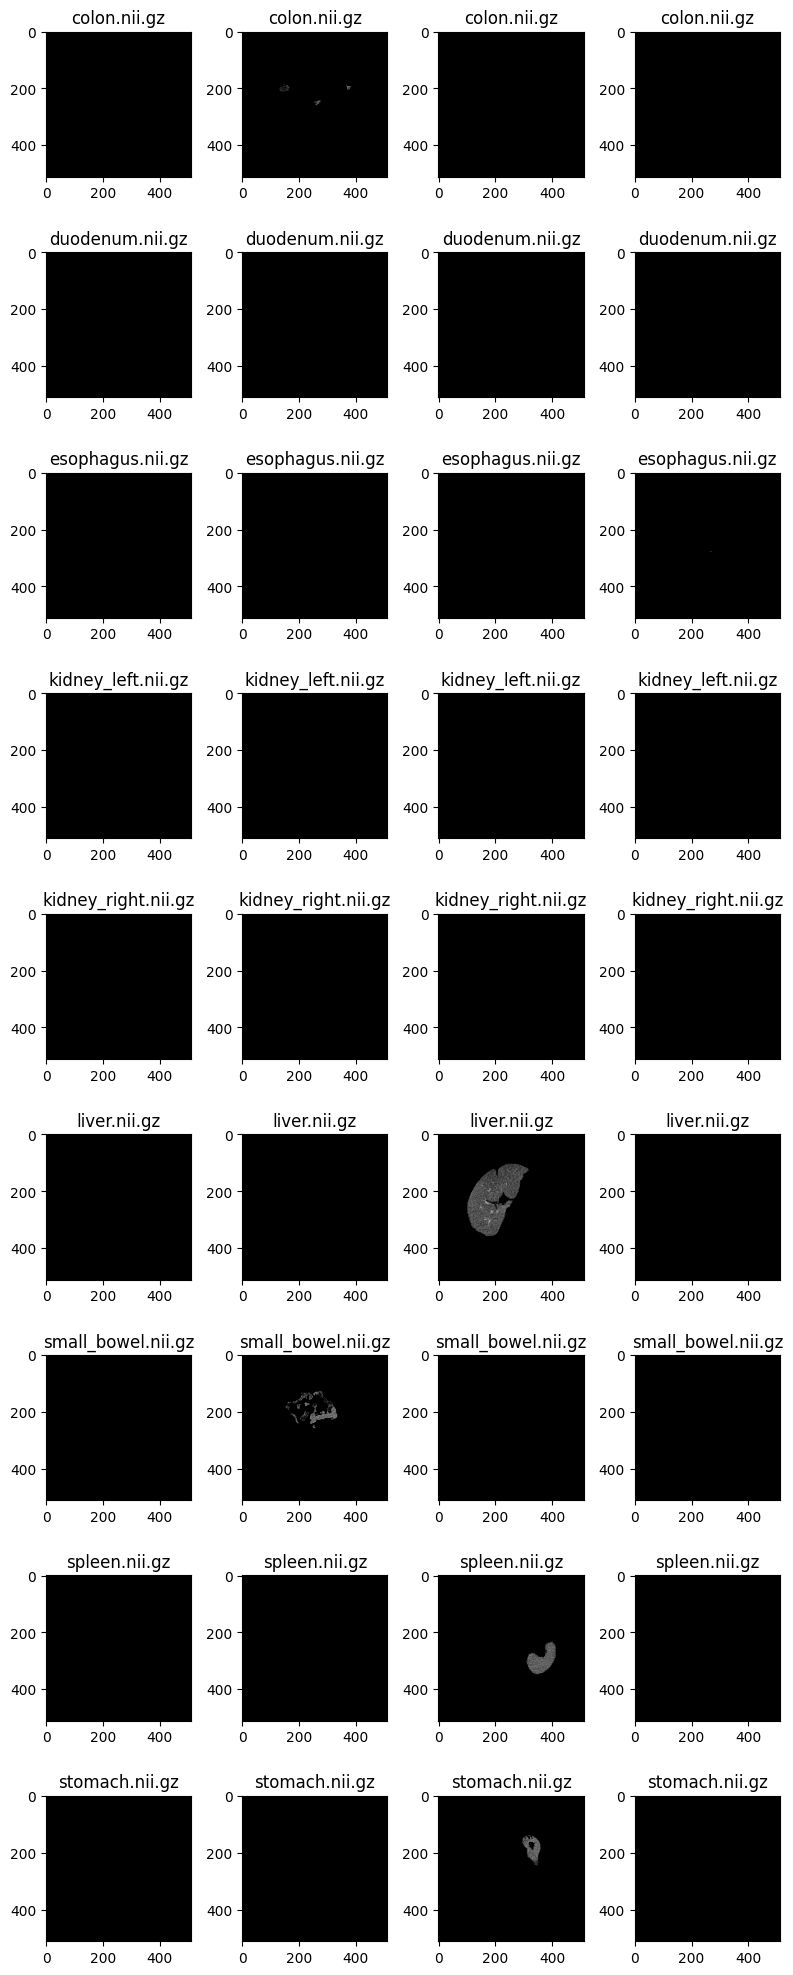

In [153]:
subject_id = 10004
run_id = 21057
folder = 'train_nifti'
folder_seg = 'train_segmented/train_images'

_, nifti_blob, _ = get_blobs('rsna-competition-2023', folder + '/' + str(subject_id) + '/' + str(run_id))
_, segm_blob, _ = get_blobs('rsna-competition-2023', folder_seg + '/' + str(subject_id) + '/' + str(run_id))

plot_segmentations(nifti_blob, segm_blob, l=4)